# Regression Models

#### Imports

In [69]:
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Custom imports
import utils
import model_utils
import linreg_utils

# Stylesheet
plt.style.use('./styles.txt')

#### Index

1. [Introduction](#intro)<br>
2. [Data Loading](#dl)<br>
    2.1 [Preprocessing](#pp)<br>
    2.2 [`FIRE_SIZE_CLASS` Distribution](#fire_dist)<br>
3. [Modelling](#modelling)<br>
    3.1 [Baseline Model](#baseline)<br>
    3.2 [Feature Selection](#feature_selection)<br>
    3.3 [Dimensionality Reduction](#dim_reduc)<br>
4. [Decision Tree Regressor](#dt_model)<br>
    4.1 [Baseline Model](#dt_base)<br>
    4.2 [Hyperparameter Optimisation](#dt_ho)<br>
5. [Reframing the Problem](#reframing)<br>
6. [Remarks on Regression](#conc)<br>

---
<a id='intro'></a>

# Introduction

In a previous notebook we created a baseline linear and logistic regression model. Unfortunately, these did not produce an accurate model and we soon realised that we should increase the number of observations from larger wildfires to allow the model to perform better. Having collected more samples, we will continue to build linear regression models in this notebook, hoping to optimise the model and yield better results than the ones achieved previously.

---
<a id='dl'></a>

## Data Loading

To begin, we need to load the data that we have collected so far.

In [3]:
df_1 = pd.read_pickle('sample_data/30k_engineered.pkl')
df_2 = pd.read_pickle('sample_data/large_fires_cleaned.pkl')

In [4]:
df_1.head()

,DATE,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,avg_tempmax,avg_temp,...,precip_variance,precip_delta,dew_variance,dew_delta,windspeed_variance,windspeed_delta,winddir_variance,winddir_delta,pressure_variance,pressure_delta
0,1992-01-01,1992,1,0.10,A,43.325000,-101.018500,SD,5.257143,-2.928571,...,0.000000,0.00,5.399184,3.5,47.062041,-1.8,1889.074286,-48.6,28.913469,-4.3
1,1992-01-01,1992,1,1.00,B,33.058333,-79.979167,SC,13.700000,9.885714,...,55.589796,-4.40,7.196327,0.1,5.575510,2.0,15648.559592,-14.9,19.071020,2.4
2,1992-01-02,1992,2,0.25,A,40.775000,-74.854160,NJ,6.385714,1.585714,...,9.546510,0.00,19.731020,4.0,34.516735,-10.6,16492.948163,-254.6,75.711429,-0.9
3,1992-01-03,1992,3,1.91,B,31.018500,-83.297300,GA,14.457143,11.828571,...,59.321224,-9.70,9.142041,-4.1,11.228571,0.2,16679.204898,223.6,21.585306,-8.4
4,1992-01-03,1992,3,2.00,B,30.728900,-87.238100,FL,14.428571,10.985714,...,0.213355,-1.32,10.262857,-7.9,27.382857,6.7,19587.093469,-24.8,13.107755,-2.7


In [5]:
df_2.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,avg_tempmax,avg_temp,avg_humidity,...,precip_variance,precip_delta,dew_variance,dew_delta,windspeed_variance,windspeed_delta,winddir_variance,winddir_delta,pressure_variance,pressure_delta
0,2003,104,232.0,D,41.363889,-88.173056,IL,14.057143,8.014286,54.885714,...,0.000000,0.00,7.864898,5.5,31.552653,11.3,4393.119592,160.9,16.827755,-9.5
1,1992,52,150.0,D,34.587299,-95.611298,OK,18.571429,11.485714,53.085714,...,0.000000,0.00,5.124898,-3.0,12.656327,3.6,5591.173469,-160.7,28.450612,6.2
2,2010,166,277.0,D,27.001200,-81.436200,FL,33.828571,27.514286,75.757143,...,0.556367,0.25,1.770612,2.8,8.504082,-4.2,6388.276735,-65.9,0.568163,-0.6
3,1992,120,125.0,D,45.966667,-68.466668,ME,8.757143,3.514286,62.514286,...,0.000000,0.00,12.290612,-7.2,17.136735,12.9,4668.631429,141.8,4.495510,-2.9
4,2011,71,285.0,D,36.279960,-93.945460,AR,13.471429,7.214286,64.271429,...,0.188278,0.00,12.262041,3.8,45.435510,2.2,8314.153878,-39.5,24.979184,-6.0


In [6]:
# Check that the shapes match
df_1.shape[1] == df_2.shape[1] 

False

In [7]:
# Drop index column
df_1.drop('DATE', axis=1, inplace=True)

# Check that the shapes match
df_1.shape[1] == df_2.shape[1] 

True

In [8]:
df = pd.concat([df_1, df_2])
df.shape

(29734, 34)

In [9]:
# Check that they were added
df.shape[0] == df_1.shape[0] + df_2.shape[0]

True

In [10]:
df.reset_index(drop=True, inplace=True)
df.head()

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,avg_tempmax,avg_temp,avg_humidity,...,precip_variance,precip_delta,dew_variance,dew_delta,windspeed_variance,windspeed_delta,winddir_variance,winddir_delta,pressure_variance,pressure_delta
0,1992,1,0.10,A,43.325000,-101.018500,SD,5.257143,-2.928571,81.142857,...,0.000000,0.00,5.399184,3.5,47.062041,-1.8,1889.074286,-48.6,28.913469,-4.3
1,1992,1,1.00,B,33.058333,-79.979167,SC,13.700000,9.885714,81.428571,...,55.589796,-4.40,7.196327,0.1,5.575510,2.0,15648.559592,-14.9,19.071020,2.4
2,1992,2,0.25,A,40.775000,-74.854160,NJ,6.385714,1.585714,67.185714,...,9.546510,0.00,19.731020,4.0,34.516735,-10.6,16492.948163,-254.6,75.711429,-0.9
3,1992,3,1.91,B,31.018500,-83.297300,GA,14.457143,11.828571,78.957143,...,59.321224,-9.70,9.142041,-4.1,11.228571,0.2,16679.204898,223.6,21.585306,-8.4
4,1992,3,2.00,B,30.728900,-87.238100,FL,14.428571,10.985714,79.971429,...,0.213355,-1.32,10.262857,-7.9,27.382857,6.7,19587.093469,-24.8,13.107755,-2.7


<a id='pp'></a>
### Preprocessing

Although we are loading in a larger DataFrame, the preprocessing stages are the same as previously as the features will not have changed. For the categorical features, namely `STATE` and `FIRE_SIZE_CLASS`, only `STATE` will be binarised into dummy variables. For the numeric columns, columns that measured the variance for the weather features will be transformed using a Box Cox transformation.

In [11]:
# Categorical preprocessing
df = utils.BasicCategoricalPreprocessing(df)

In [12]:
# Check the output
df.head(2)

,FIRE_YEAR,DISCOVERY_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,avg_tempmax,avg_temp,avg_humidity,avg_precip,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,1992,1,0.1,A,43.325000,-101.018500,5.257143,-2.928571,81.142857,0.000000,...,1,0,0,0,0,0,0,0,0,0
1,1992,1,1.0,B,33.058333,-79.979167,13.700000,9.885714,81.428571,4.185714,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Numeric preprocessing
df, boxcox_cols = utils.BasicNumericPreprocessing(df)

# Check the output of the transformations
utils.HistogramSubplots(df[boxcox_cols])

<a id='fire_dist'></a>

### `FIRE_SIZE_CLASS` Distribution

One of the biggest problems that we experienced in the building of the initial regression and classification models was that we did not have enough observations of larger fires, in fact, only 0.1% of the observations in the previous data pertained to `FIRE_SIZE_CLASS` G. Let us see how the distribution differs this time.

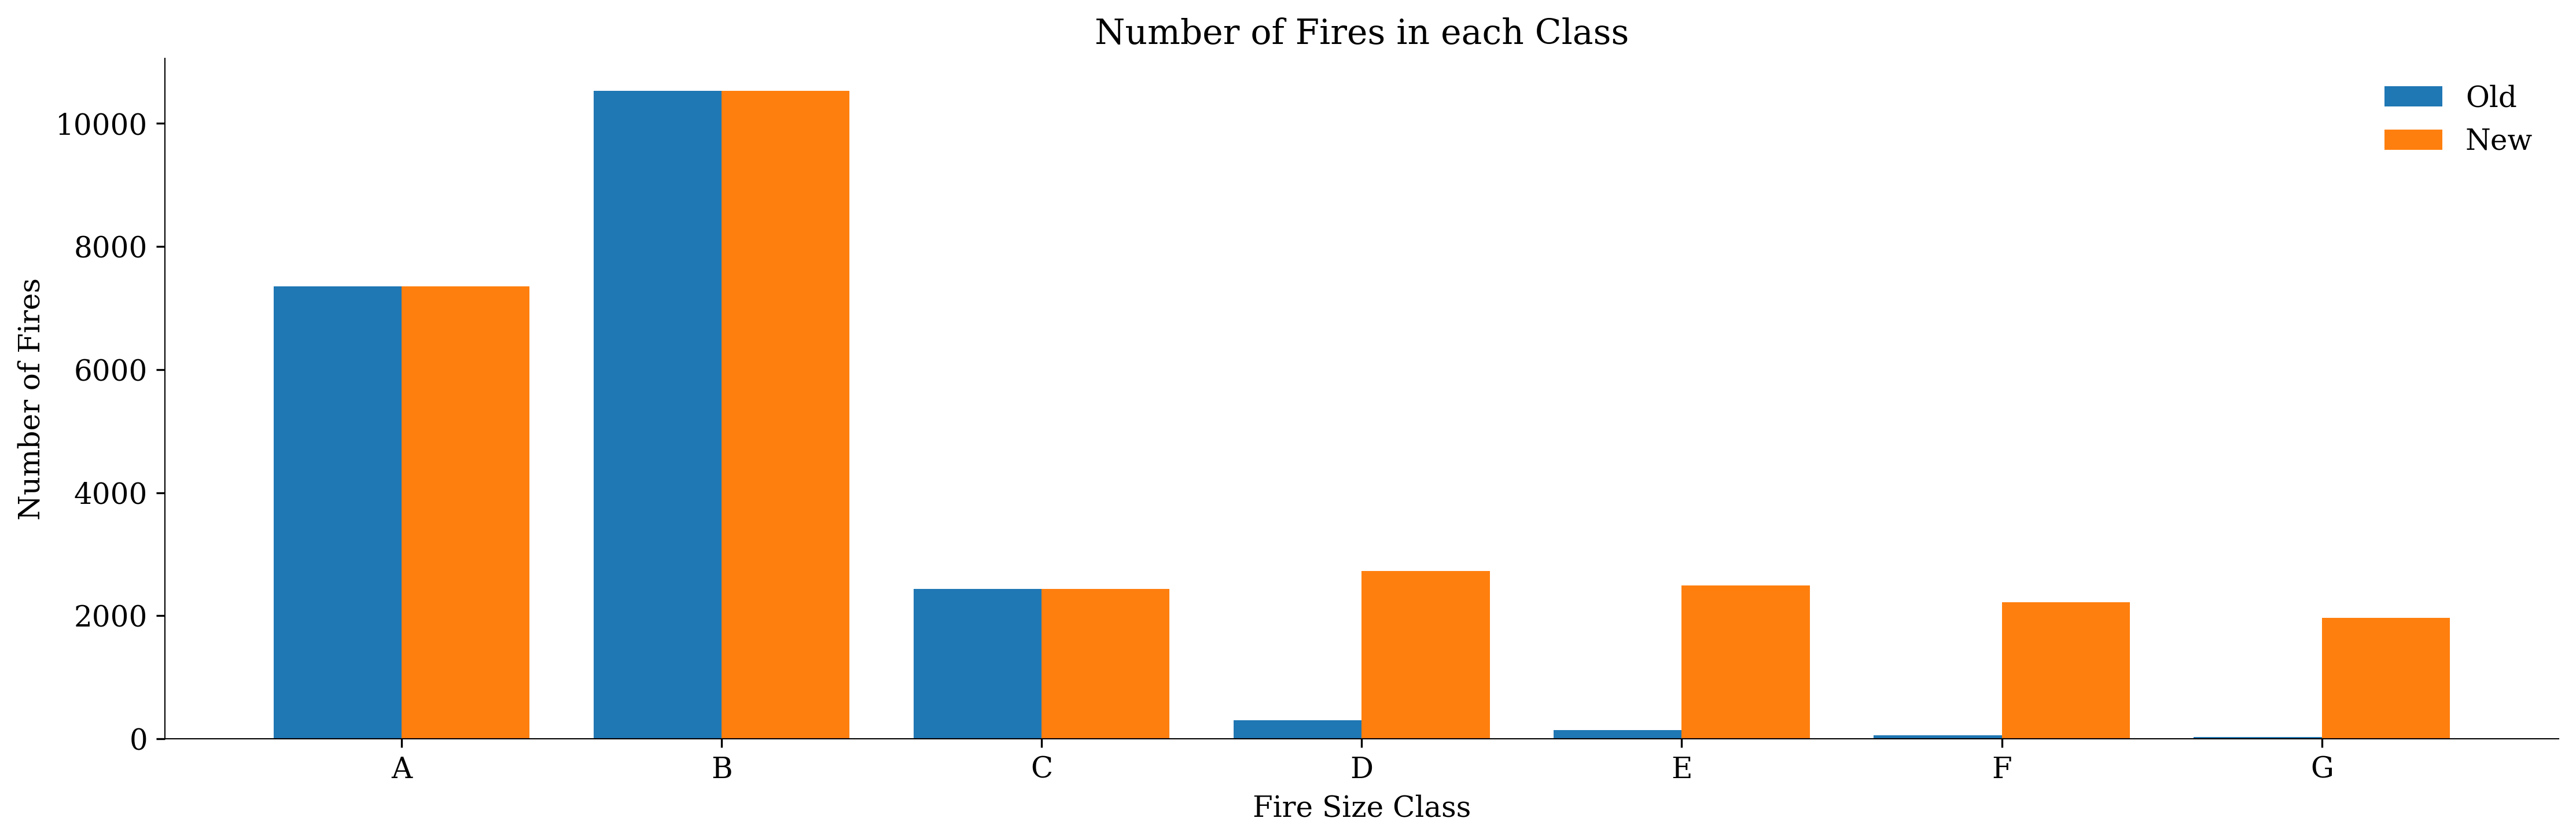

In [14]:
# Create DataFrame for the values
old = utils.count_percentage_df(df_1['FIRE_SIZE_CLASS']).sort_index()
new = utils.count_percentage_df(df['FIRE_SIZE_CLASS']).sort_index()

# Change the 
comparison = pd.DataFrame()

for name, temp_df in zip(['old', 'new'], [old, new]):
    for col in ['Count']:
        col_name = f'{name}'
        comparison[col_name] = temp_df[col]

X = comparison.index
old_count = comparison['old']
new_count = comparison['new']
  
X_axis = np.arange(len(X))

plt.figure(figsize=(15, 5))
plt.bar(X_axis - 0.2, old_count, 0.4, label = 'Old')
plt.bar(X_axis + 0.2, new_count, 0.4, label = 'New')
plt.xlabel("Fire Size Class")
plt.ylabel("Number of Fires")
plt.title("Number of Fires in each Class")
plt.xticks(X_axis, X)
plt.legend()
plt.show()

We see then that there are significantly more fires from the minority classes, however these are still underrepresented in comparison to classes A and B. Regardless, we will begin by creating a baseline model.

---
<a id='modelling'></a>
## Modelling

In this section of the notebook, we will conduct our modelling process. Initially, we will create a baseline model, after which we will begin to optimise the model using a variety of methods. This will include improving the model by conducting a feature selction and dimensionality reduction process.

<a id='baseline'></a>
### Baseline Model

In [70]:
# Get predictors and target
X = df.drop(['FIRE_SIZE', 'FIRE_SIZE_CLASS'], axis=1)
y = df['FIRE_SIZE']

# Create column transformer
column_transformer = model_utils.CreateColumnTransformer(X)

In [71]:
# Check the shape of the predictors
X.shape

(29734, 83)

In [72]:
from sklearn.model_selection import train_test_split

# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit the column transformer
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

In [73]:
from sklearn.linear_model import LinearRegression

# Instantiate model
base_linreg = LinearRegression()

# Fit model
base_linreg.fit(X_train_transformed, y_train)

# Score model
print(f"R-squared: {base_linreg.score(X_test_transformed, y_test)}")

R-squared: 0.07046651118799652


In [74]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = base_linreg.predict(X_test_transformed)

print(f'MAE: {mean_absolute_error(y_test, y_pred):,}')
print(f'RMSE: {mean_squared_error(y_test, y_pred):,}')

MAE: 3,047.137327557674
RMSE: 229,468,614.97858346


Immediately we see that the performance of this model has increased and is no longer returning a negative $R^2$ value. We do see however that the MAE and RMSE have increased significantly, meaning that althought the features are a better indicator of fire size, our predictions are still very far off the actual value. Is there perhaps a way we can improve upon these metrics? 

<a id='feature_selection'></a>

### Feature Selection

By conducting feature selection we are hoping to determine the features within the data set that are better indicators of our target variable. By removing features, we are simplifying the linear model that we are creating as the coefficients for fewer featuers needs to be calculated. Before we begin our feature selection process, let us take a look at the current values for the coefficients calculated in the model so far.

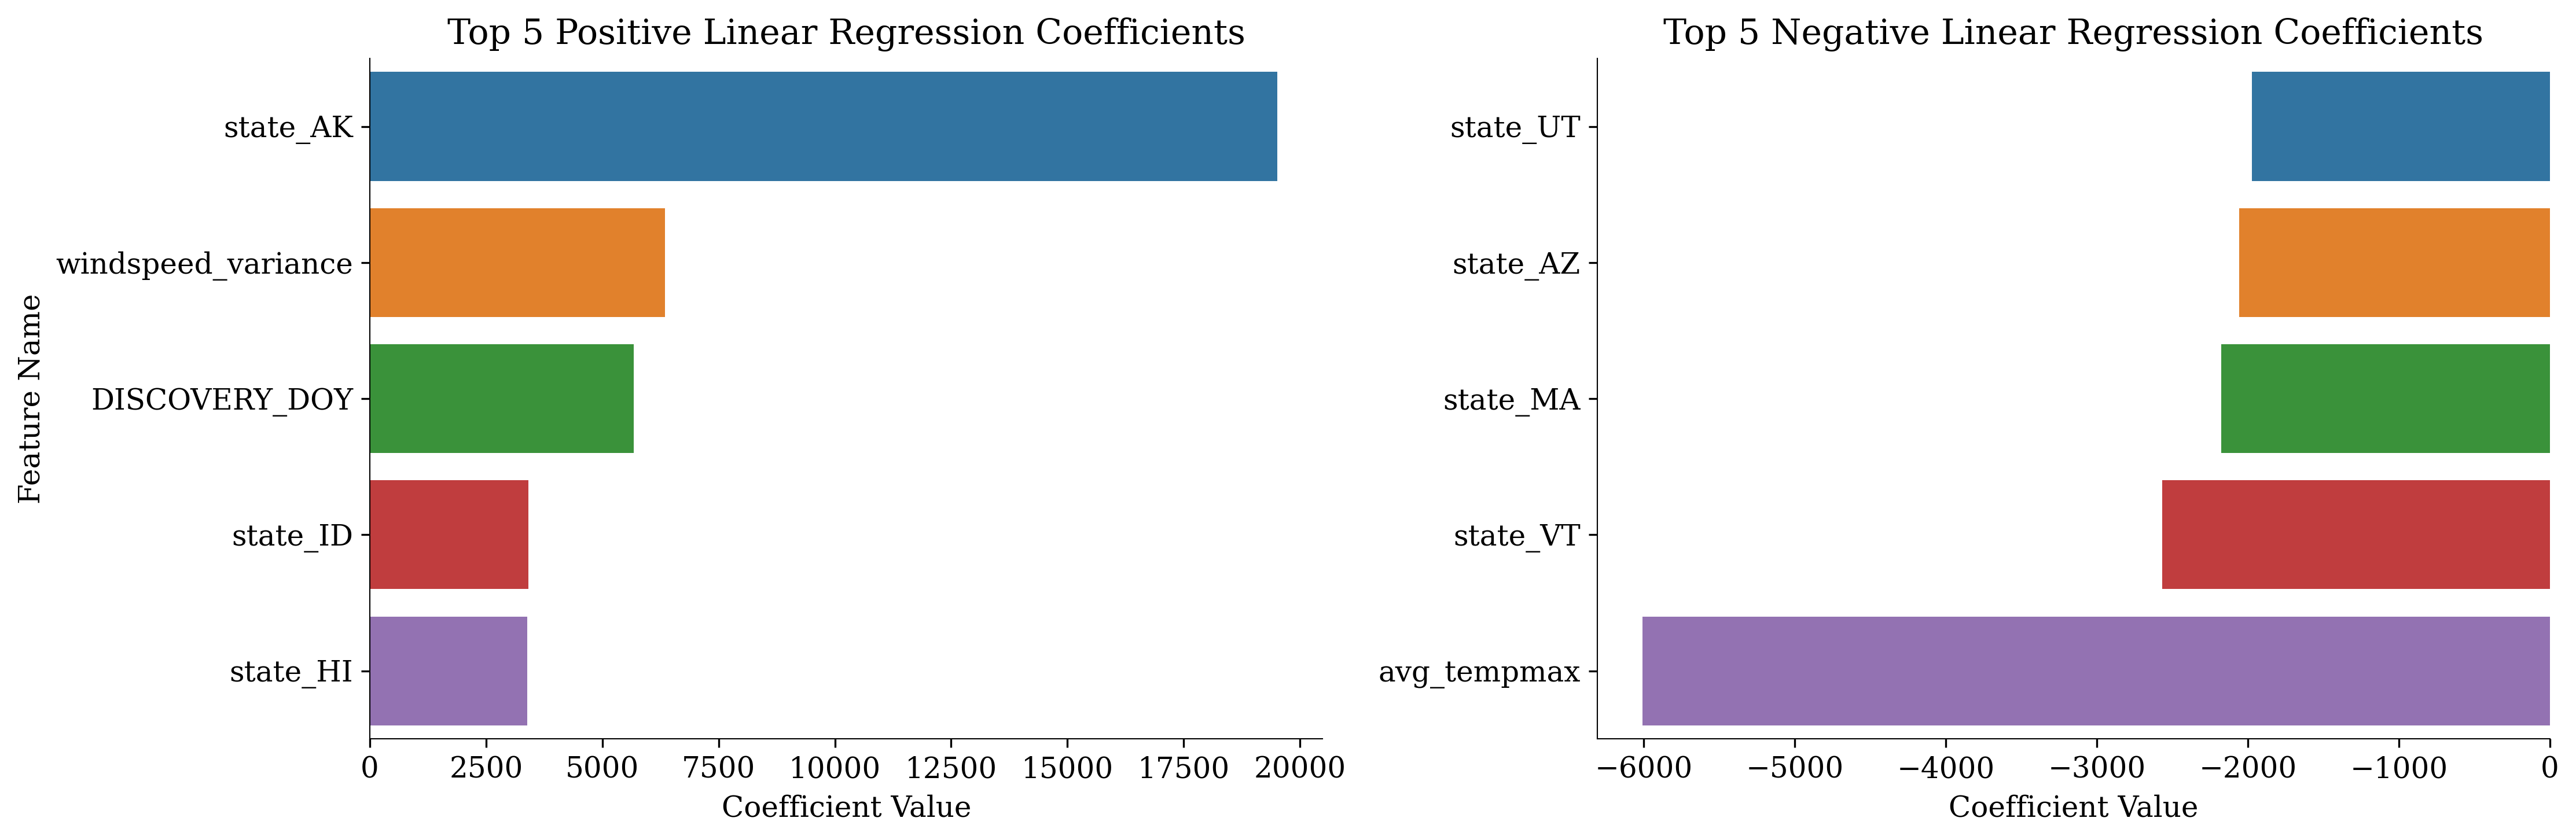

In [20]:
model_utils.PlotCoefficients(base_linreg, X)

From this plot we see that the largest and smallest coefficients have changed to the coefficients that we saw before. While previously `windspeed_variance` had the largst positive coefficient, it is the fact that a fire is in Alaska that determines the size of the wildfire. Again, this seems to lead us to the conclusion that we reached earlier - a state which has a high proportion of large wildfires will heavily influence the outcome of a model. Interestingly, the coefficient with the smallest value is `avg_tempmax`, although this is surprising, considering that warmer temperatures leading up to a fire should provide the optimal environment for a wildfire to grow. Let us begin our feature engineering by reducing the multicollinearity of the model. As before, we can use Lasso Regression to determine which are the most important features.

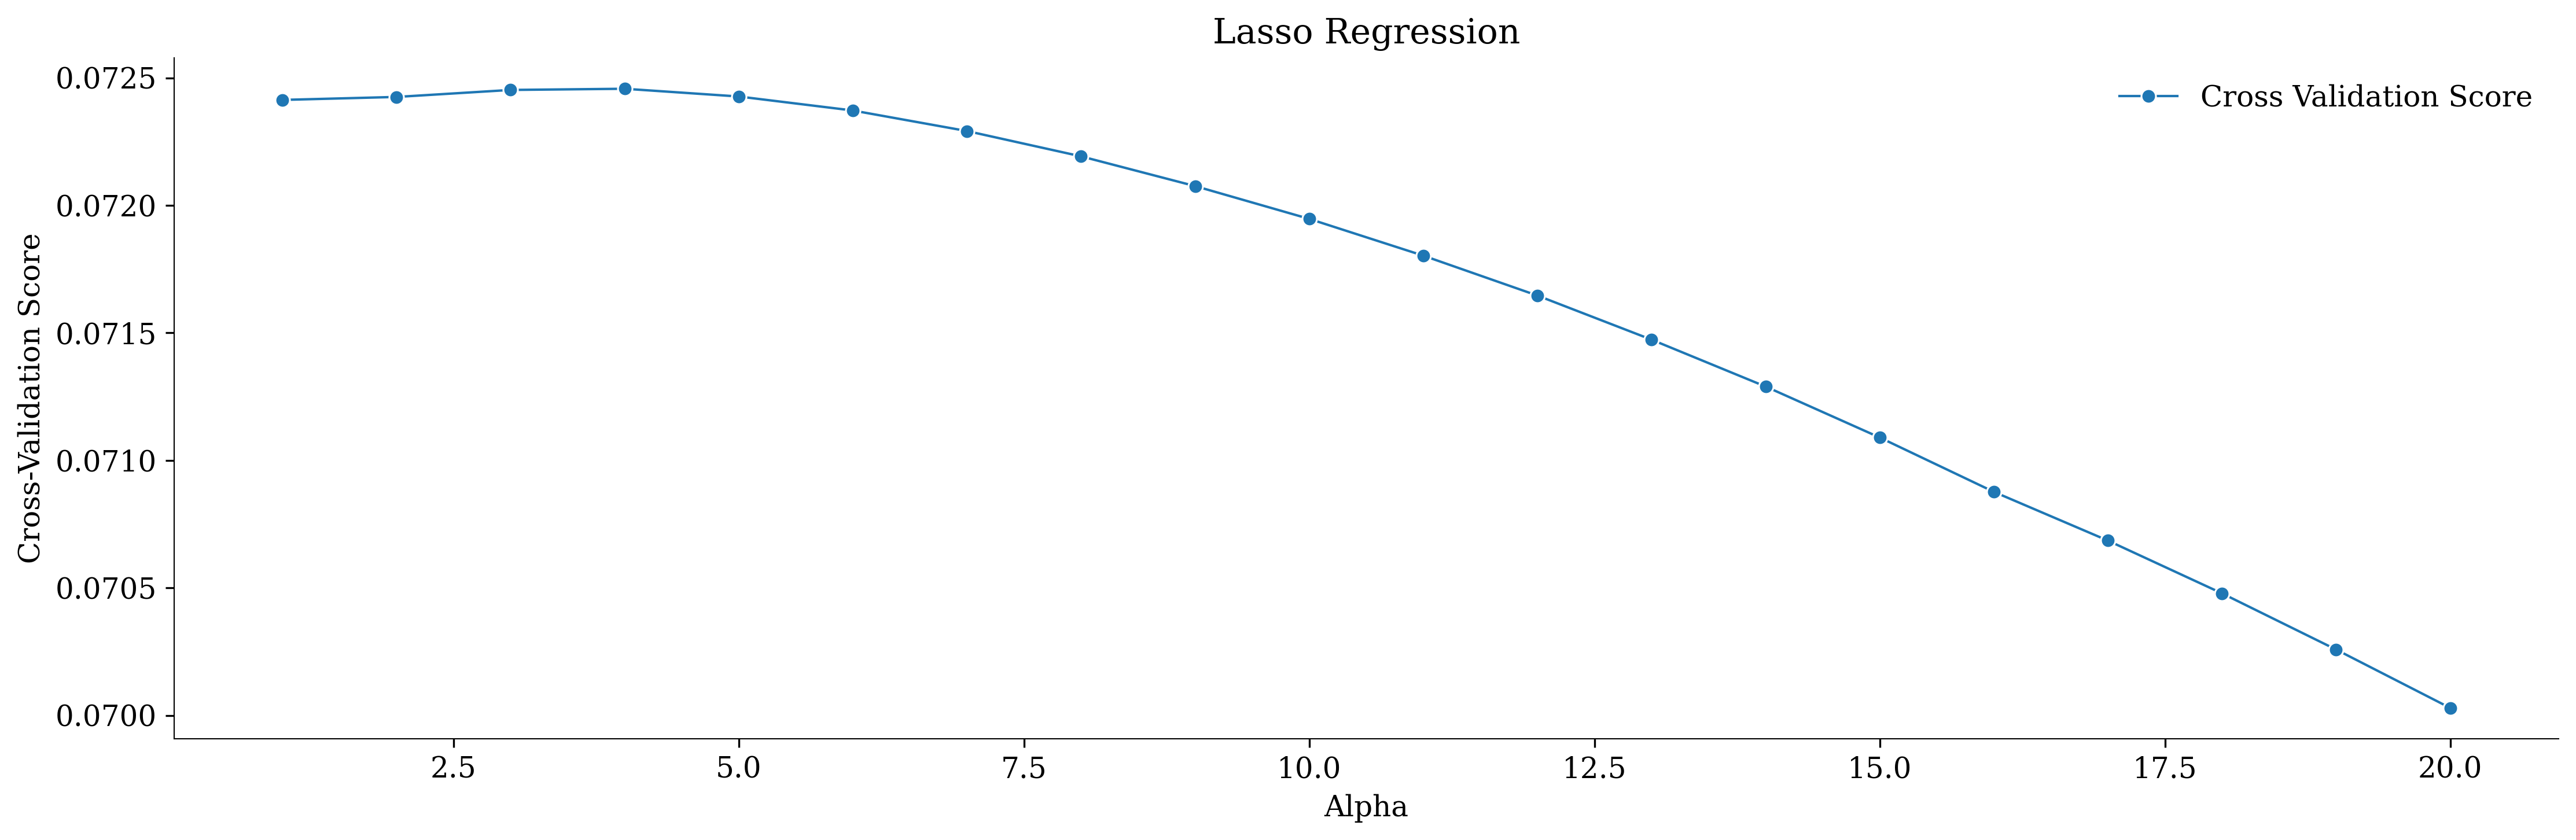

In [75]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import cross_val_score

alphas = list(range(1, 21))

cross_val_scores = []

for alpha in alphas:
    print(f'Fitting model {alpha}', end=' \r')
    lasso = Lasso(alpha=alpha)
    cv_score = np.mean(cross_val_score(lasso, X_train_transformed, y_train, cv = 2))
    cross_val_scores.append(cv_score)
    
plt.figure(figsize=(15, 5))
plt.title('Lasso Regression')
sns.lineplot(x=alphas, y=cross_val_scores, marker='o', label='Cross Validation Score')
plt.xlabel('Alpha')
plt.ylabel('Cross-Validation Score')
plt.show()

We see, generally, that increasing the alpha value - and therefore reducing the number of features in our model - reduces the accuracy of the model. That being said, we do see that the cross-validation score does increase slightly whilst the alpha value is below 5. What is the alpha value that generated the highest score, and what were the features of this model?

In [76]:
alphas[np.argmax(cross_val_scores)]

4

In [25]:
lasso = Lasso(alpha=4)
lasso.fit(X_train_transformed, y_train)

Lasso(alpha=4)

In [26]:
lasso_df = pd.DataFrame({'Coefficient Value':lasso.coef_}, index=X.columns)

In [35]:
lasso_df[lasso_df['Coefficient Value'] == 0]

,Coefficient Value
state_AL,-0.0
state_CA,-0.0
state_CT,-0.0
state_DC,0.0
state_DE,-0.0
state_HI,0.0
state_IA,-0.0
state_IL,-0.0
state_IN,0.0
state_KS,0.0


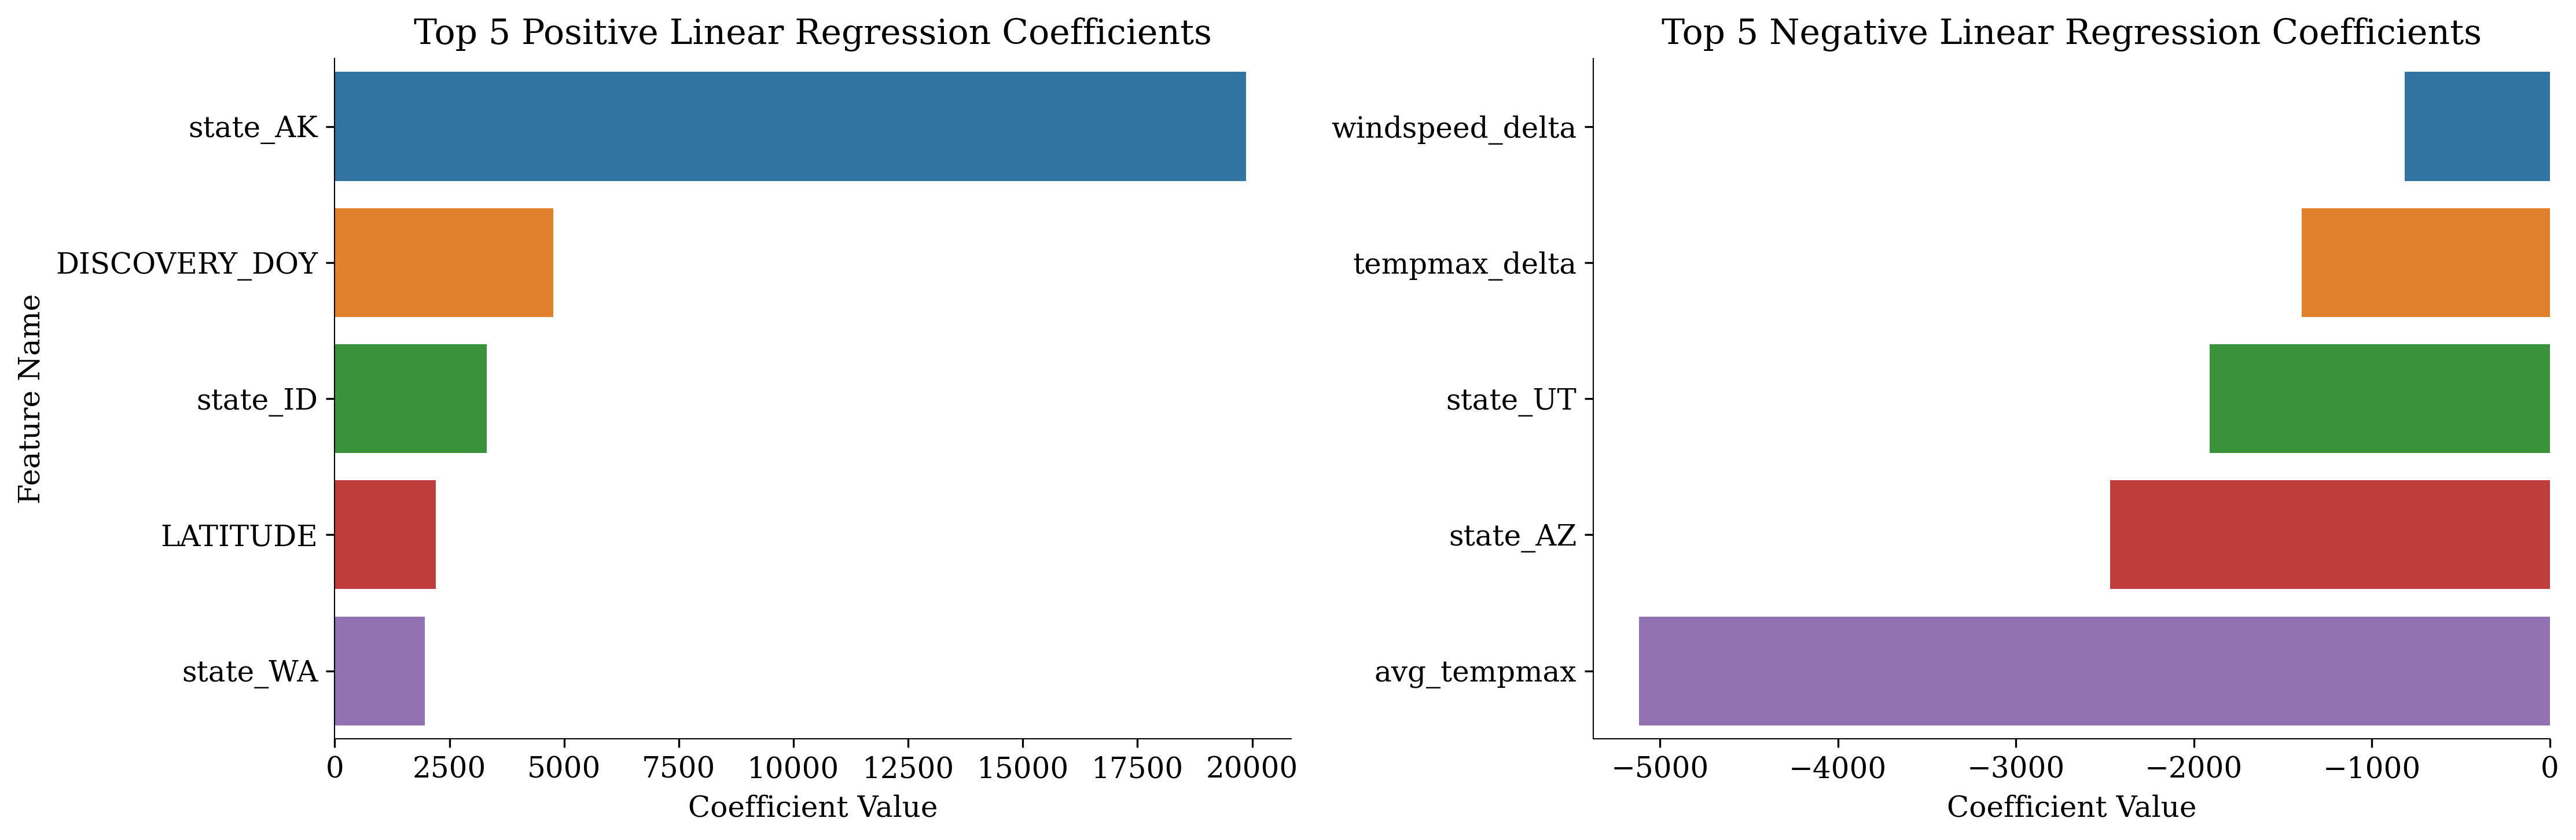

In [39]:
model_utils.PlotCoefficients(lasso, X)

We see that the model set the coefficients of many of the state variables to 0. Despite this, states still play an important role in the prediction of fire size considering that these features account for 5 of the 10 features shown in the plots above. We can create a model that uses only these features in order to see whether this would create a more accurate model.

In [40]:
base_linreg_df = pd.DataFrame({'coef': base_linreg.coef_}, index=X.columns)\
    .sort_values(by='coef', ascending=False)
top_5_features = base_linreg_df.index.values[:5]

bottom_5_features = base_linreg_df.index.values[-5:]
features = np.append(top_5_features, bottom_5_features)
features

array(['state_AK', 'windspeed_variance', 'DISCOVERY_DOY', 'state_ID',
       'state_HI', 'state_UT', 'state_AZ', 'state_MA', 'state_VT',
       'avg_tempmax'], dtype=object)

In [41]:
X_train, X_test, y_train, y_test = \
train_test_split(X[features], y, test_size=0.2, random_state=1)

In [42]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer

ss_col = ['windspeed_variance', 'avg_tempmax']
mm_col = ['DISCOVERY_DOY']

col_transforms = [('standard scale', StandardScaler(), ss_col),
                    ('minmax scale', MinMaxScaler(), mm_col)] 

optimised_col_transformer = ColumnTransformer(col_transforms, remainder='passthrough')

X_train_transformed = optimised_col_transformer.fit_transform(X_train)
X_test_transformed = optimised_col_transformer.transform(X_test)

optimised_linreg = LinearRegression()
optimised_linreg.fit(X_train_transformed, y_train)

optimised_linreg.score(X_test_transformed, y_test)

0.057981993321075675

In [43]:
y_pred = optimised_linreg.predict(X_test_transformed)

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'RMSE: {mean_squared_error(y_test, y_pred):,}')

MAE: 3079.4713674573695
RMSE: 232,550,596.48659676


This has increased both the value of the MAE and RMSE, while decreasing the value of the $R^2$ value. Generally, it seems that reducing the number of features yields no better models. But perhaps we can achieve a better model using alternative methods of dimensionality reduction, namely Principal Component Analysis (PCA).

<a id='dim_reduc'></a>
### Dimensionality Reduction

By using PCA we are hoping to find a linear combination of variables that accounts for a larger proportion of the data's variance.

In [111]:
from sklearn.decomposition import PCA

# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Fit the column transformer
X_train_transformed = column_transformer.fit_transform(X_train)
X_test_transformed = column_transformer.transform(X_test)

# Initialise PCA
pca = PCA()

# Fit and transform test and train
X_train_pca = pca.fit_transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)

# Create linear model
pca_linreg = LinearRegression()
pca_linreg.fit(X_train_pca, y_train)

LinearRegression()

In [112]:
linreg_utils.ScoreModel(pca_linreg, X_test_pca, y_test)

Model Evaluation
R-squared: 0.0705
RMSE:      229468614.9786
MAE:       3047.1373


This did not yield a better result - we can also try reducing the dimensionality of the model by using the `n_components` argument.

In [110]:
# Initialise PCA
pca = PCA(n_components=0.9)

# Fit and transform test and train
X_train_pca = pca.fit_transform(X_train_transformed)
X_test_pca = pca.transform(X_test_transformed)

# Create linear model
pca_linreg = LinearRegression()
pca_linreg.fit(X_train_pca, y_train)

linreg_utils.ScoreModel(pca_linreg, X_test_pca, y_test)

Model Evaluation
R-squared: 0.0001
RMSE:      246833889.2253
MAE:       3319.4172


Unfortunately, it seems that in terms of linear regression models, the features are not good indicators. While a linear regression model has been unsuccessful in accurately predicting the size of a wildfire, there are other linear regression models we can try, such as a Decision Tree regressor.

---

<a id='dt_model'></a>

## Decision Tree Regressor

While the previous model we used was unsuccessful in generating a high $R^2$ value, we have other methods. One of these is the Decision Tree regressor. A decision tree regressor is a machine learning algorithm that can be used to predict continuous values. It works by splitting the data into smaller groups, making predictions for each group, and then combining the predictions to get a final estimate. Why would a decision tree regressor perform better than a linear regression model? There are many reasons a decision tree regressor could perform better than a linear regression model. Some reasons could be that the data is non-linear, or that the linear model is overfitting the data. As a result, using this alternate approach to our data set we may be able to create a better model. There are other benefits to using a decision tree regressor too, including:

1. They are easy to interpret and explain.
2. They can handle both linear and nonlinear relationships.
3. They are resistant to overfitting.
4. They can be used for feature selection.

We will begin by creating a baseline model, after which we will then continue to try to optimise the model.

<a id='dt_base'></a>

### Baseline Model

While we had to scale the features in the previous model, a Decision Tree does not require feature scaling.

In [50]:
from sklearn.tree import DecisionTreeRegressor

X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

base_DT_model = DecisionTreeRegressor()
base_DT_model.fit(X_rem, y_rem)

DecisionTreeRegressor()

In [51]:
base_DT_model.score(X_test, y_test)

-0.8328156586831357

Again, this model performs poorly, however there are a number of hyperparameters we can tune to perhaps improve upon this.

<a id='dt_ho'></a>

### Hyperparameter Optimisation

One of the most important features of a decision tree is the max depth. We will therefore begin this process of optimisation by trying to find the optimium max depth.

In [52]:
# Create train and validation set
X_train, X_validation, y_train, y_validation = \
train_test_split(X_rem, y_rem, test_size=0.3, random_state=1)

# Initialise lists
depths = list(range(1, int(np.sqrt(len(X_train)))))
train_scores = []
validation_scores = []

for depth in depths:
    print(f'Fitting model {depth}/{max(depths)}', end='\r')
    
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    
    train_scores.append(dt.score(X_train, y_train))
    validation_scores.append(dt.score(X_validation, y_validation))

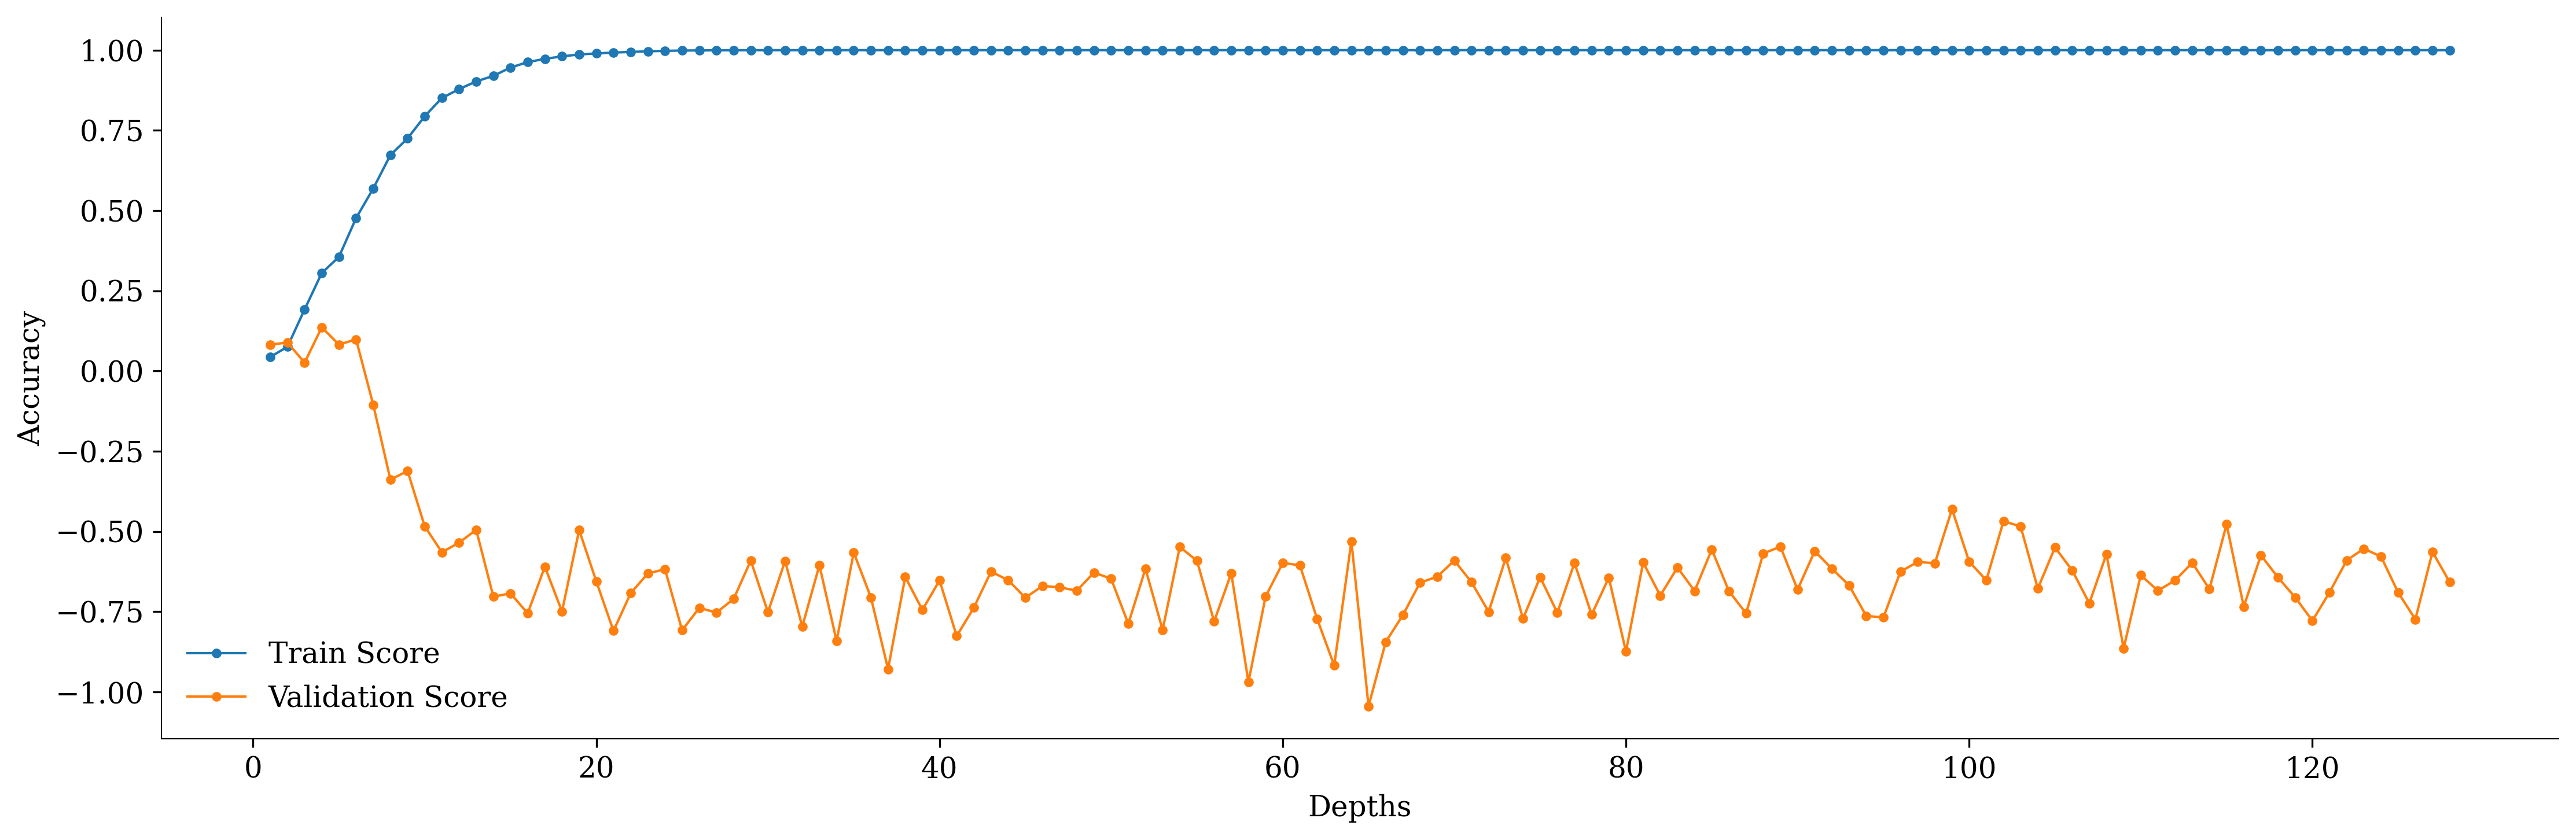

In [53]:
model_utils.PlotTrainTest(depths, 'Depths', train_scores, validation_scores, validation=True)

In [54]:
optimum_depth = depths[np.argmax(validation_scores)]
print(f'The highest validation accuracy was achieved with a max depth of {optimum_depth}.')

The highest validation accuracy was achieved with a max depth of 4


We can now calculate the model scores for a Decision Tree regressor that uses this depth.

In [55]:
dt = DecisionTreeRegressor(max_depth=optimum_depth)
dt.fit(X_train, y_train)

linreg_utils.ScoreModel(dt, X_test, y_test)

Model Evaluation
R-squared: -0.23743608861308774
RMSE:      305478768.43196756
MAE:       3108.559461968009


Despite the relatively high validation score, the model with a `max_depth` of 4 performed poorly. We could run a grid search on this model, hoping to improve the outcome, however this seems somewhat gratuitous and unproductive. Rather, we could narrow the scope of our regression model, such that it aims to be a better predictor of smaller fires rather than all the fires in the data set.

In [166]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# from tempfile import mkdtemp

# # Create cache
# cachedir = mkdtemp()

# # Create estimators
# estimators = [('model', DecisionTreeRegressor())]

# # Create pipeline
# pipe = Pipeline(estimators)

# # Different parameters to test
# param_grid = [
#     {
#         'model__criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
#         'model__splitter': ['best', 'random'],
#         'model__max_depth': [i for i in range(1, 11)],
#         'model__min_samples_split': [i for i in range(1, 21, 2)],
#         'model__min_samples_leaf': [i for i in range(1, 11)],
#         'model__max_features': ['auto', 'sqrt', 'log2']
#     }
# ]

# grid = GridSearchCV(pipe, param_grid, cv=5, verbose=1)
# fitted_grid = grid.fit(X_train, y_train)

---
<a id='reframing'></a>
## Reframing the Problem

So far we have tried to build a regression model that tries to determine fire size for a wide variety of fires. This obviously is a difficult task when the fire size of a wildfire ranges as much as it does in this data set. What we can therefore do is focus purely on the fires that fall within the classes A-D. This would still allow us to differentiate between small and larger fires and is therefore still a worthwhile task.

Let us remind ourselves of how wildfire sizes are distributed.

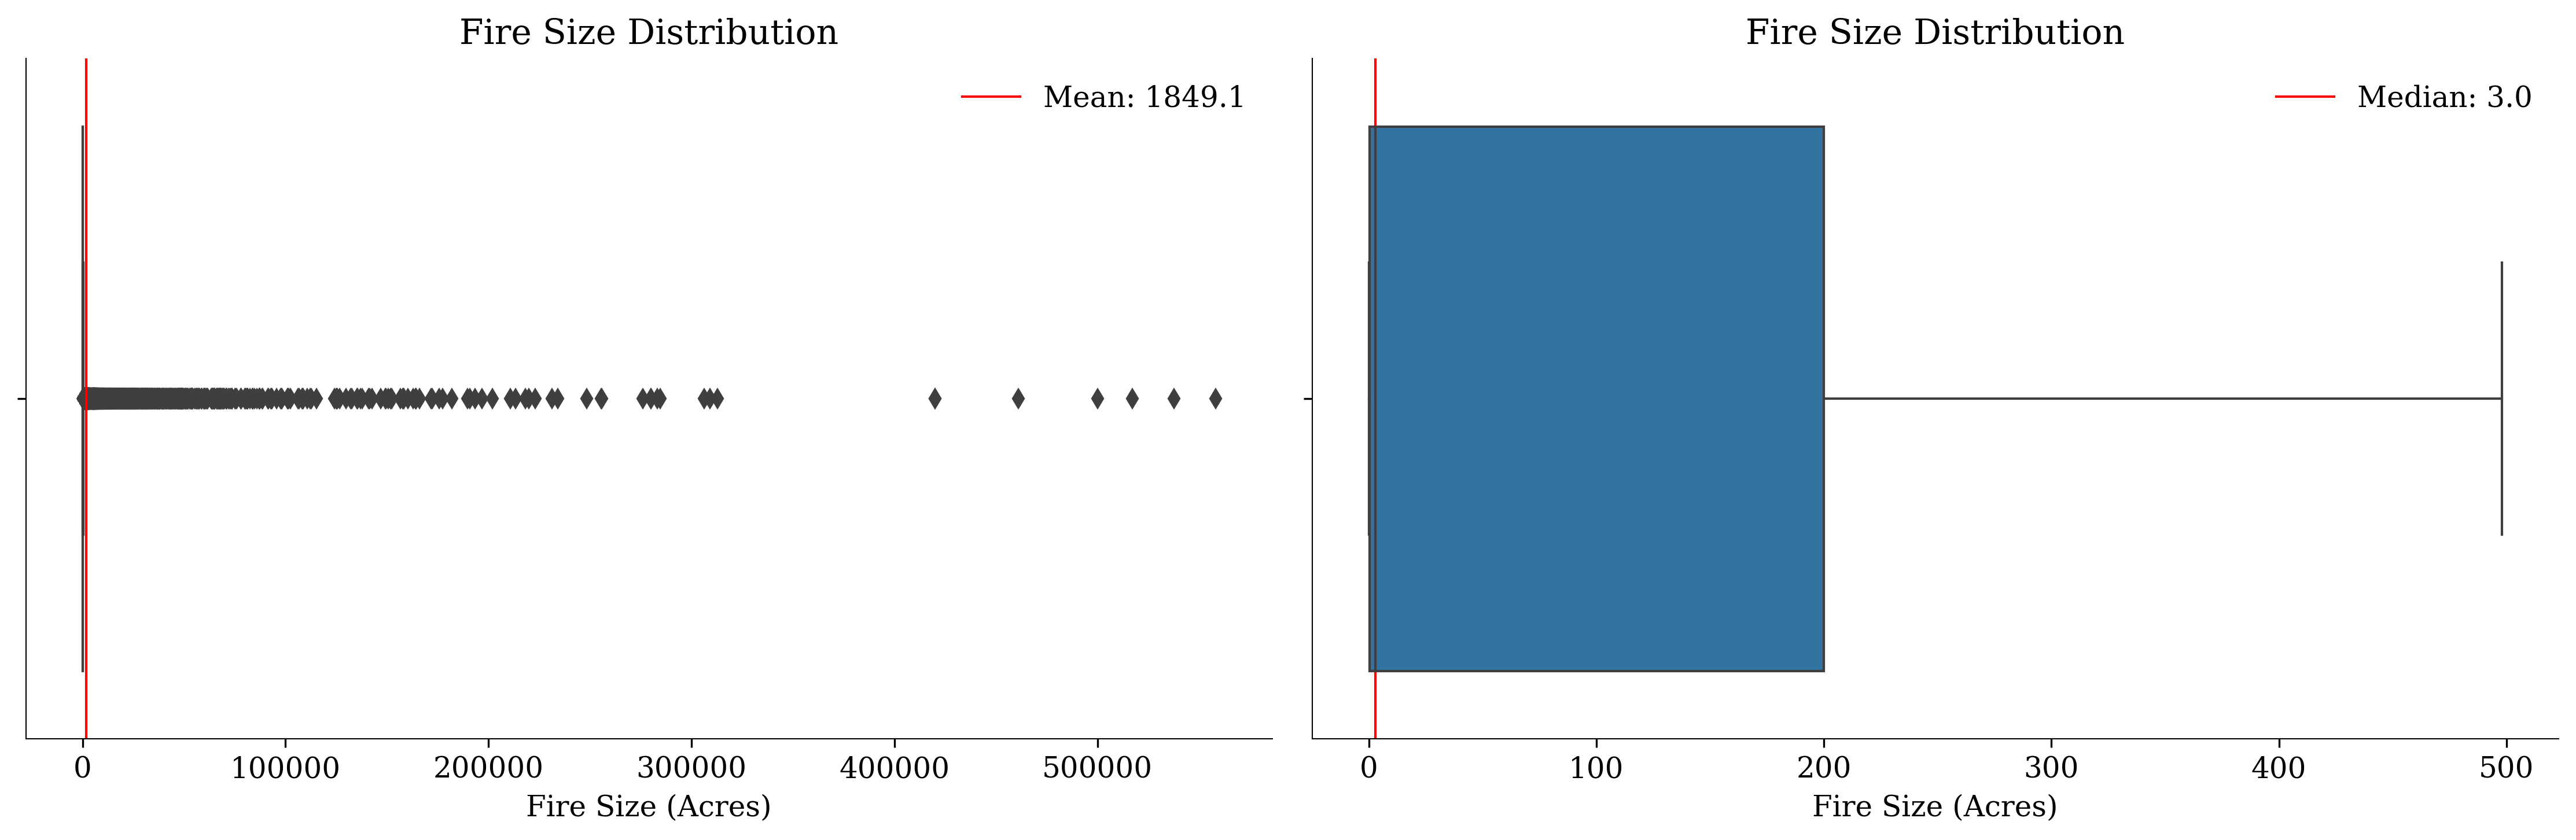

In [56]:
utils.PlotFireSizeDistribution(df)

Wildfires in class D have an upper bound of 300 acres, meaning that we are able to get a decent proportion of values within our data set. Let us begin by removing the other classes from the DataFrame, from which we can then build a Linear Regression model.

In [57]:
classes = ['A', 'B', 'C', 'D']

aDdf = df[df['FIRE_SIZE_CLASS'].isin(classes)]

utils.BasicEda(aDdf, 'Wildfires [Classes A-D]', components=['shape', 'columns', 'dtypes'])

WILDFIRES [CLASSES A-D]
-----------------------

Rows: 23053    Columns: 85

FIRE_YEAR            int64
DISCOVERY_DOY        int64
FIRE_SIZE          float64
FIRE_SIZE_CLASS     object
LATITUDE           float64
                    ...   
state_VT             uint8
state_WA             uint8
state_WI             uint8
state_WV             uint8
state_WY             uint8
Length: 85, dtype: object

Number of categorical columns: 1
Number of numeric columns: 84


In [58]:
X = aDdf.drop(['FIRE_SIZE', 'FIRE_SIZE_CLASS'], axis=1)
y = aDdf['FIRE_SIZE']

X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_rem_transformed = column_transformer.fit_transform(X_rem)
X_test_transformed = column_transformer.fit(X_test)

ad_linreg = LinearRegression()
ad_linreg.fit(X_rem, y_rem)

linreg_utils.ScoreModel(ad_linreg, X_test, y_test)

Model Evaluation
R-squared: 0.07640297095063753
RMSE:      2818.104559566449
MAE:       32.031802596890905


Immediately, we see that the MAE and RMSE values are far lower than in previous models. Perhaps now it would be useful to conduct some sort of feature engineering to determine which features are the most important when predicting smaller wildfires. We can also determine good predictors of fire size by looking at the coefficients for the model we have just created.

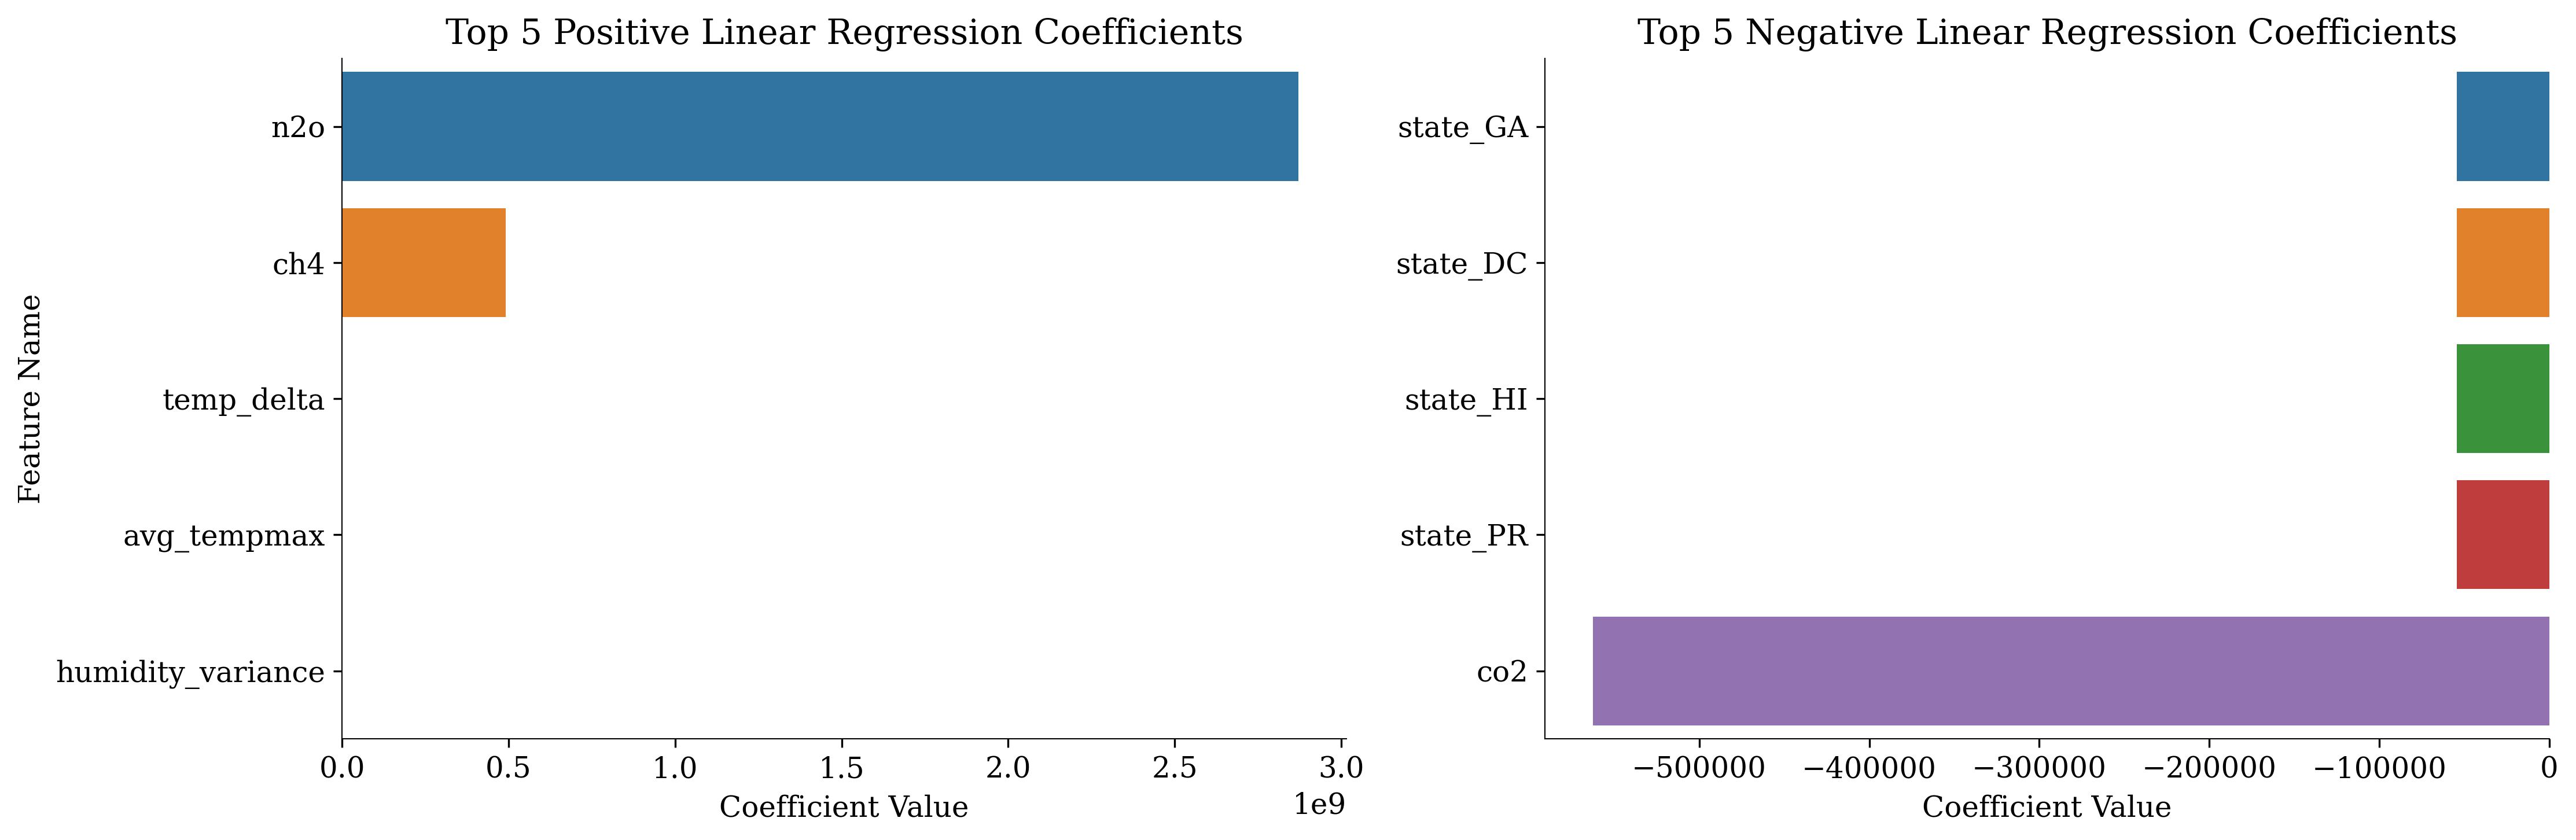

In [59]:
model_utils.PlotCoefficients(ad_linreg, X)

We see that the emissions data plays an important role in determining fire size. That being said, the positive values are very small meaning that even these features don't correlate highly with the target. 

Next, let us see how a Lasso regression performs as the alpha increases.

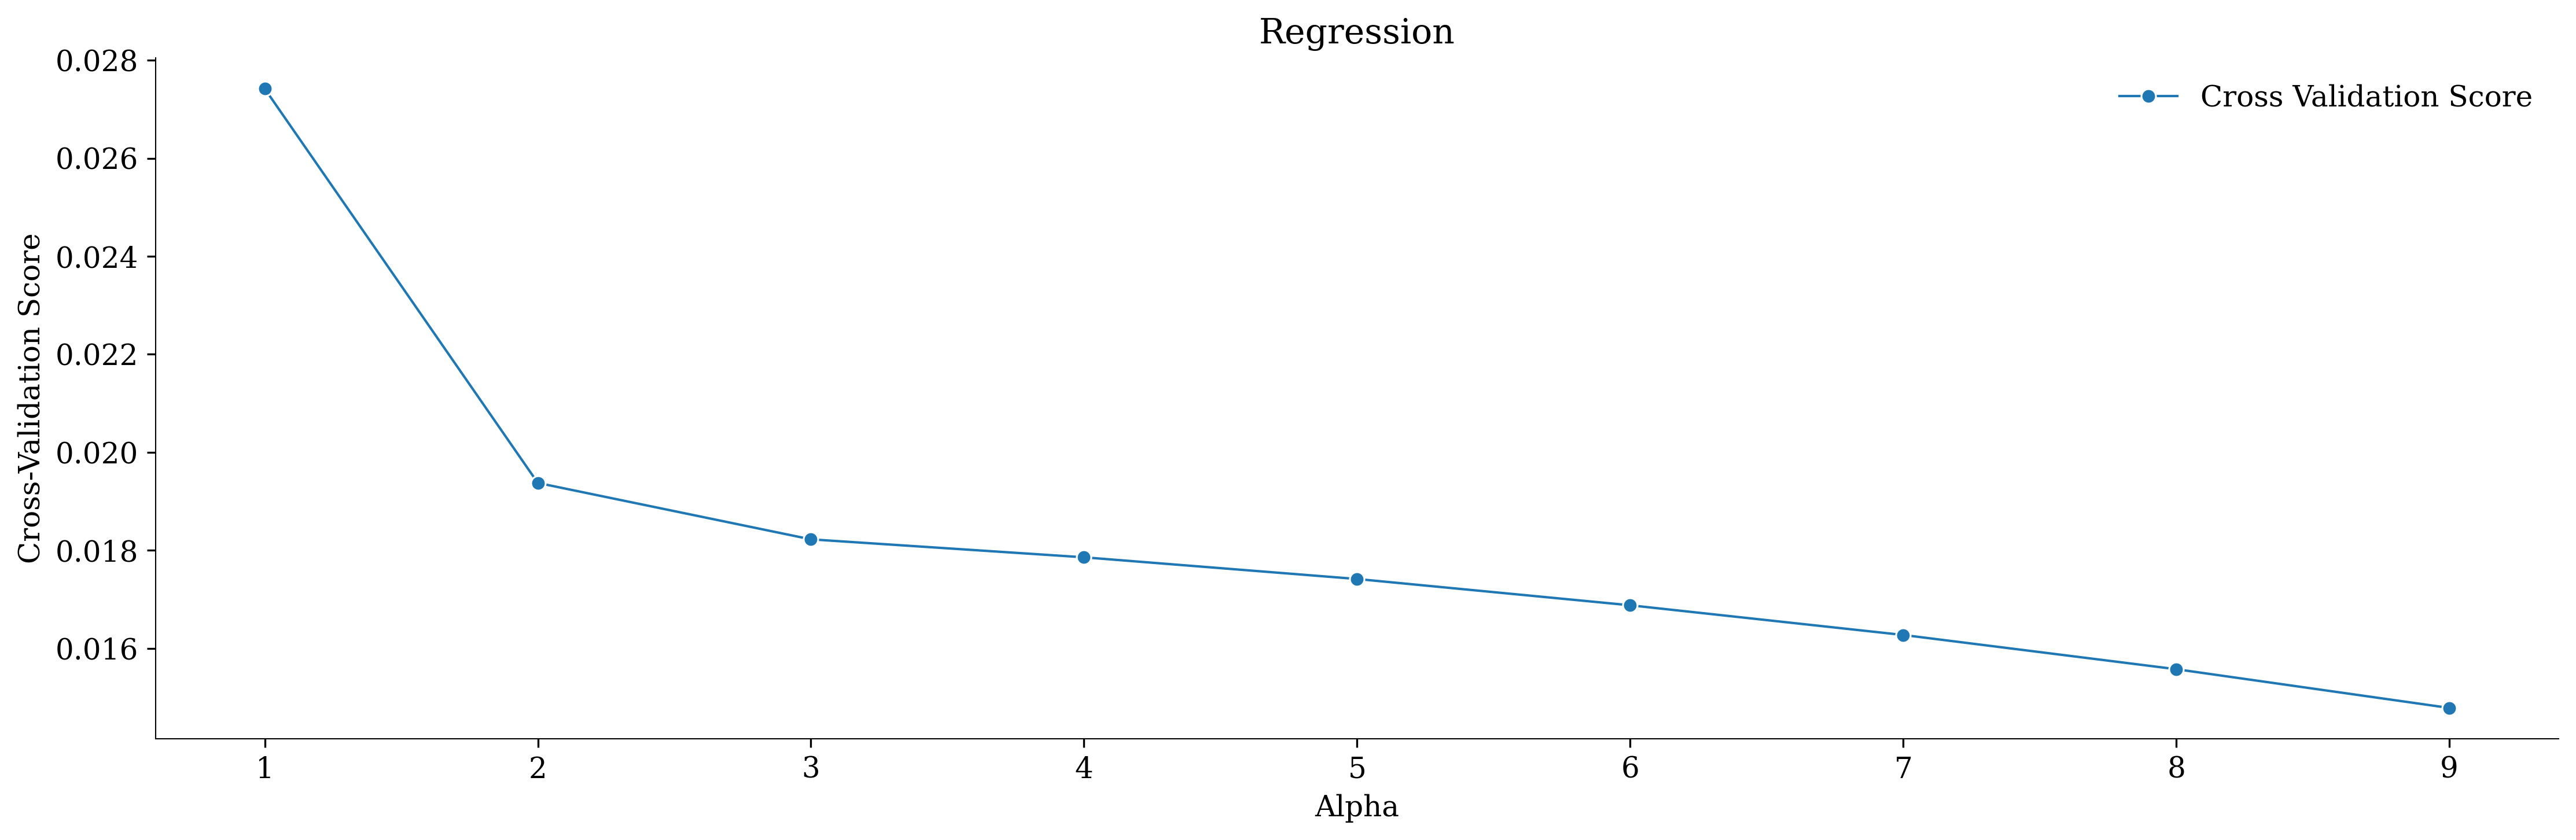

In [61]:
X = aDdf.drop(['FIRE_SIZE', 'FIRE_SIZE_CLASS'], axis=1)
y = aDdf['FIRE_SIZE']

X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

linreg_utils.PlotAlphaRegression(X_rem, y_rem, Lasso, list(range(1, 10)))

Again here we see that as features are removed the accuracy of the model decreases significantly. Finally, we can also use a Decision Tree Regressor on the smaller DataFrame.

In [62]:
X = aDdf.drop(['FIRE_SIZE', 'FIRE_SIZE_CLASS'], axis=1)
y = aDdf['FIRE_SIZE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

dt = DecisionTreeRegressor()

dt.fit(X_train, y_train)

linreg_utils.ScoreModel(dt, X_test, y_test)

Model Evaluation
R-squared: -0.7360479594000158
RMSE:      5297.07709762429
MAE:       35.21941965083496


As with the other models, we can see the most important features within this model:

In [68]:
importances = dt.tree_.compute_feature_importances(normalize=False)
importances_df = pd.DataFrame({'Variable': X_train.columns,
                               'Importance': importances})
importances_df.sort_values(by='Importance', ascending=False)

,Variable,Importance
3,LONGITUDE,282.624433
2,LATITUDE,206.425965
25,windspeed_variance,133.658494
10,avg_winddir,129.052177
9,avg_windspeed,126.436589
...,...,...
42,state_HI,0.000000
31,state_AK,0.000000
51,state_MD,0.000000
34,state_AZ,0.000000


Interestingly, we see that in a baseline Decision Tree Regressor, the most important features are different to those calculated in other models. While in the linear regression, emissions data had the highest coefficient values, in the decision tree it is the longitude and latitude that is most important in determining the size of a fire. We also saw, through our Lasso regression, that a reduction in dimensionality decreased the score of our model, meaning that the features present in our data set are not good predictors of fire size.

---
<a id='conc'></a>
## Remarks on Regression

Unfortunately, regression models are unable to perform well given the data available. While we started by looking at the fires from a large variety of sizes, we decided to focus purely on smaller fires. Despite this, models were unable to achieve high $R^2$ values while having high RMSE and MAE values. Different features were determined important by different models, which is an interesting, but unhelpful, observation. From this point, we can try to focus on classification models, rather than regression models, considering that `FIRE_SIZE_CLASS` is another feature that is present in the data.